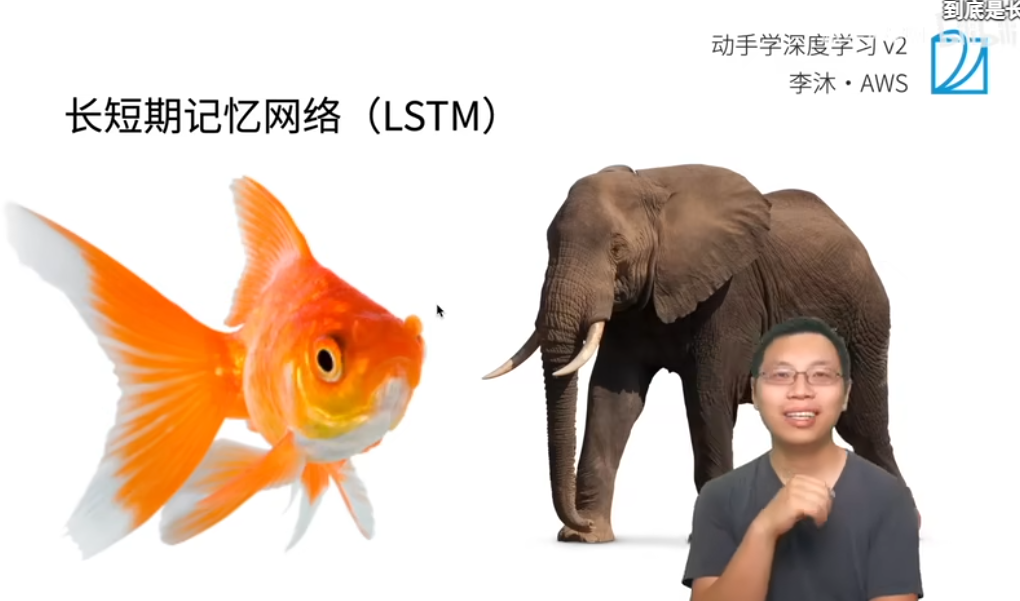

隐变量模型存在着长期信息保存和短期输入缺失的问题

LSTM比GRU多了一些东西

长短期记忆网络的设计灵感来自于计算机的逻辑门，长短期记忆网络引入了记忆元（memory cell），或简称为单元（cell）


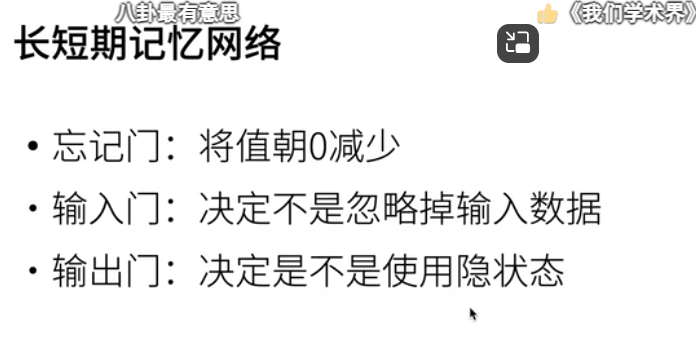

LSTM有三个门

# LSTM的三个门

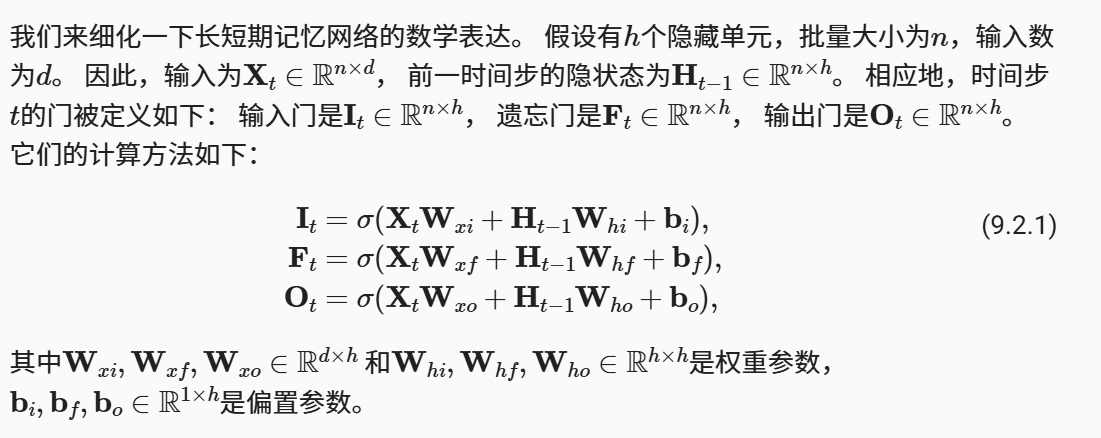

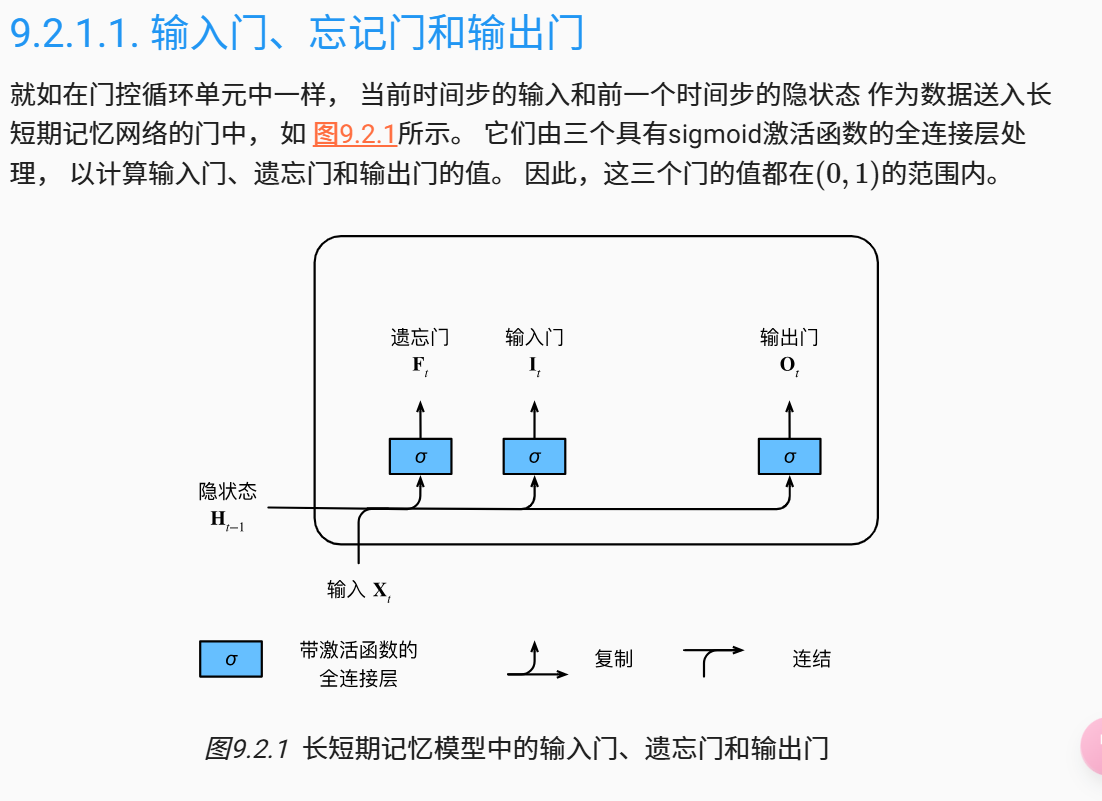

# 候选记忆单元

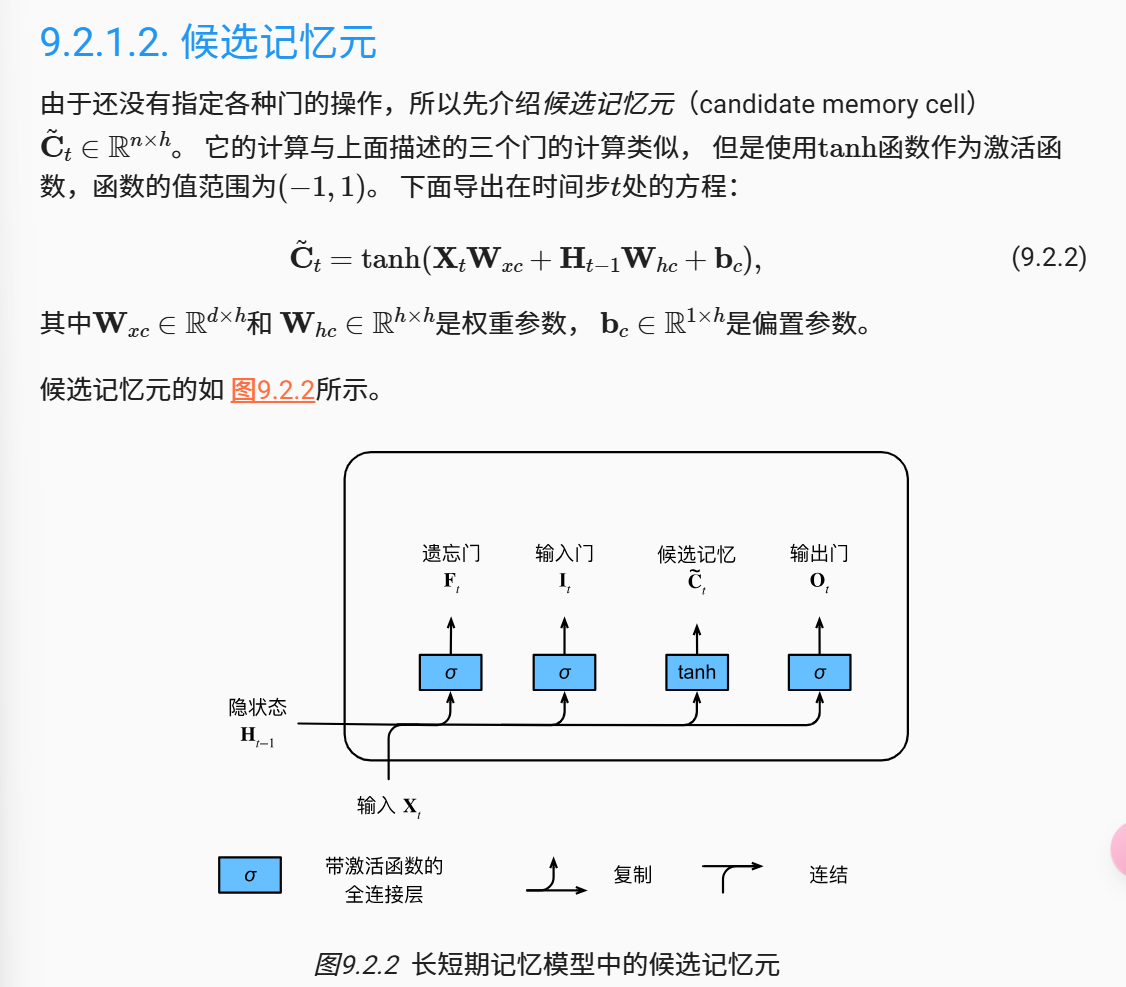

# 记忆单元

上一个时刻记忆单元会作为时刻放入下一个记忆单元

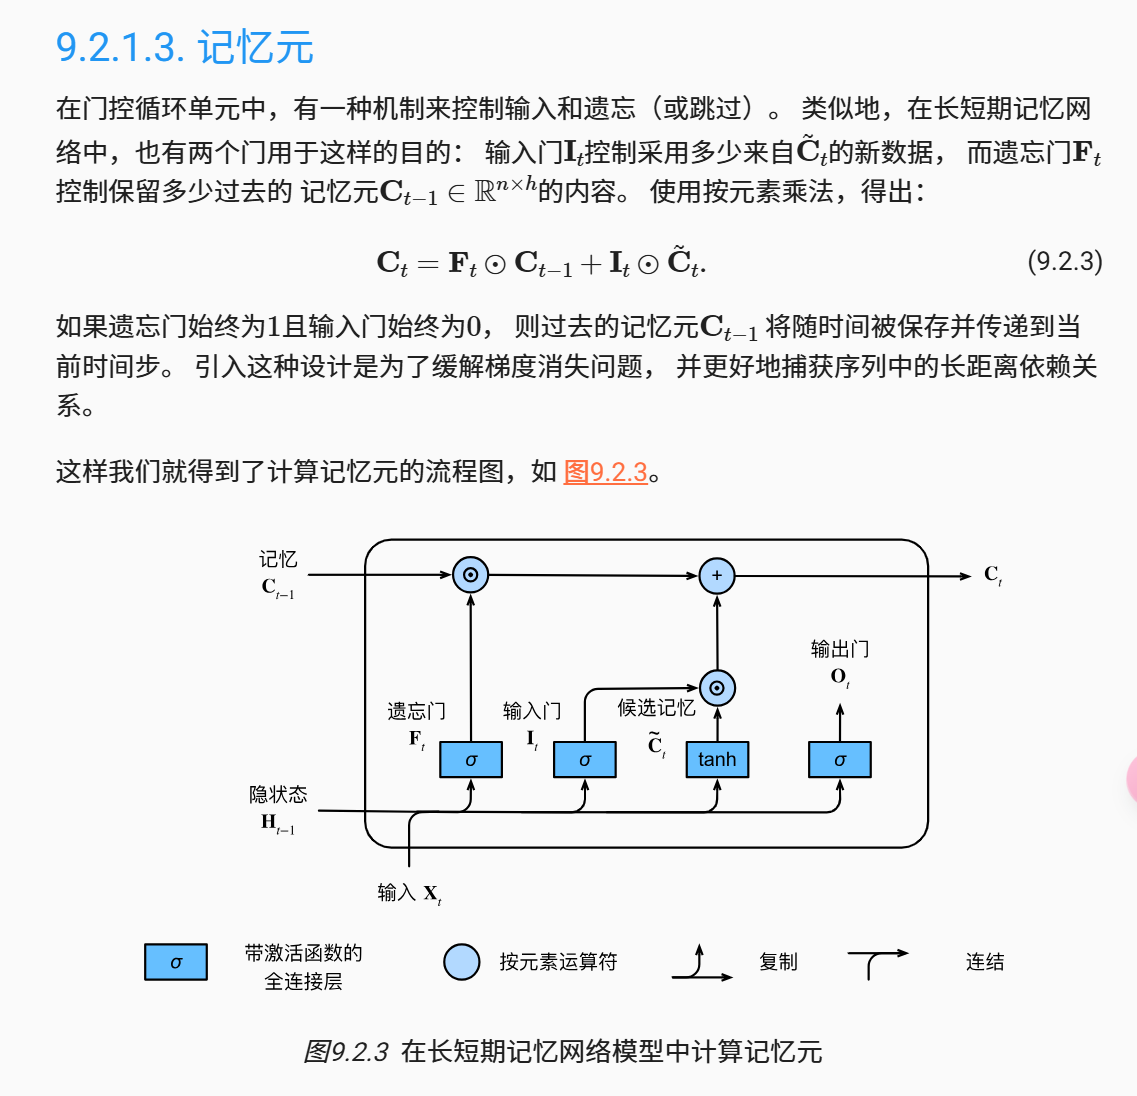



# 隐状态

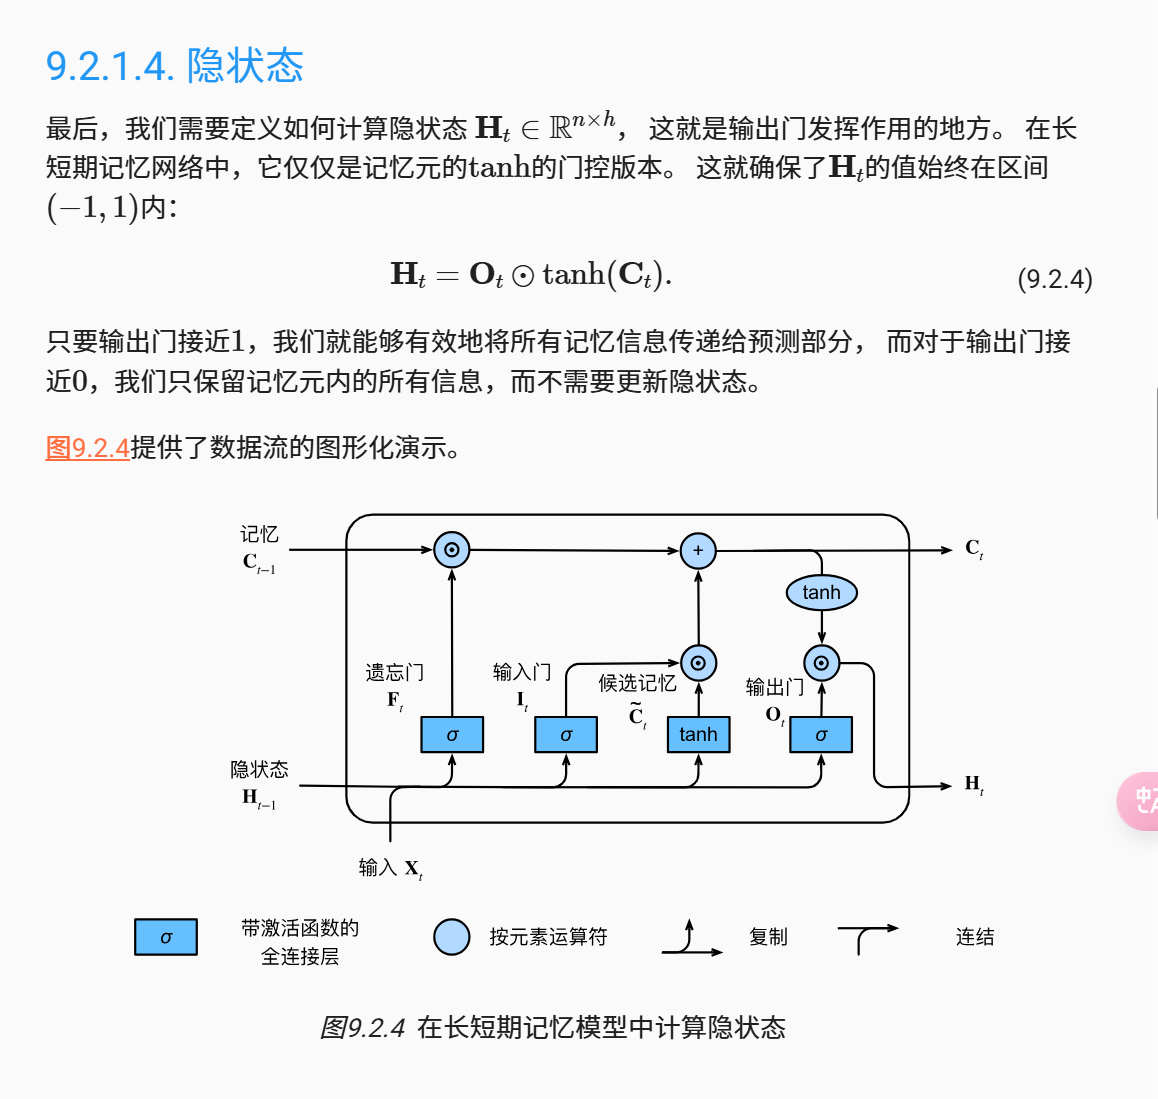

长短期记忆网络（LSTM，Long Short-Term Memory network）是一种特殊的循环神经网络（RNN），用于处理和预测序列数据中的长程依赖关系。LSTM 网络能够有效地解决传统 RNN 在处理长期依赖时容易出现的梯度消失和梯度爆炸问题。

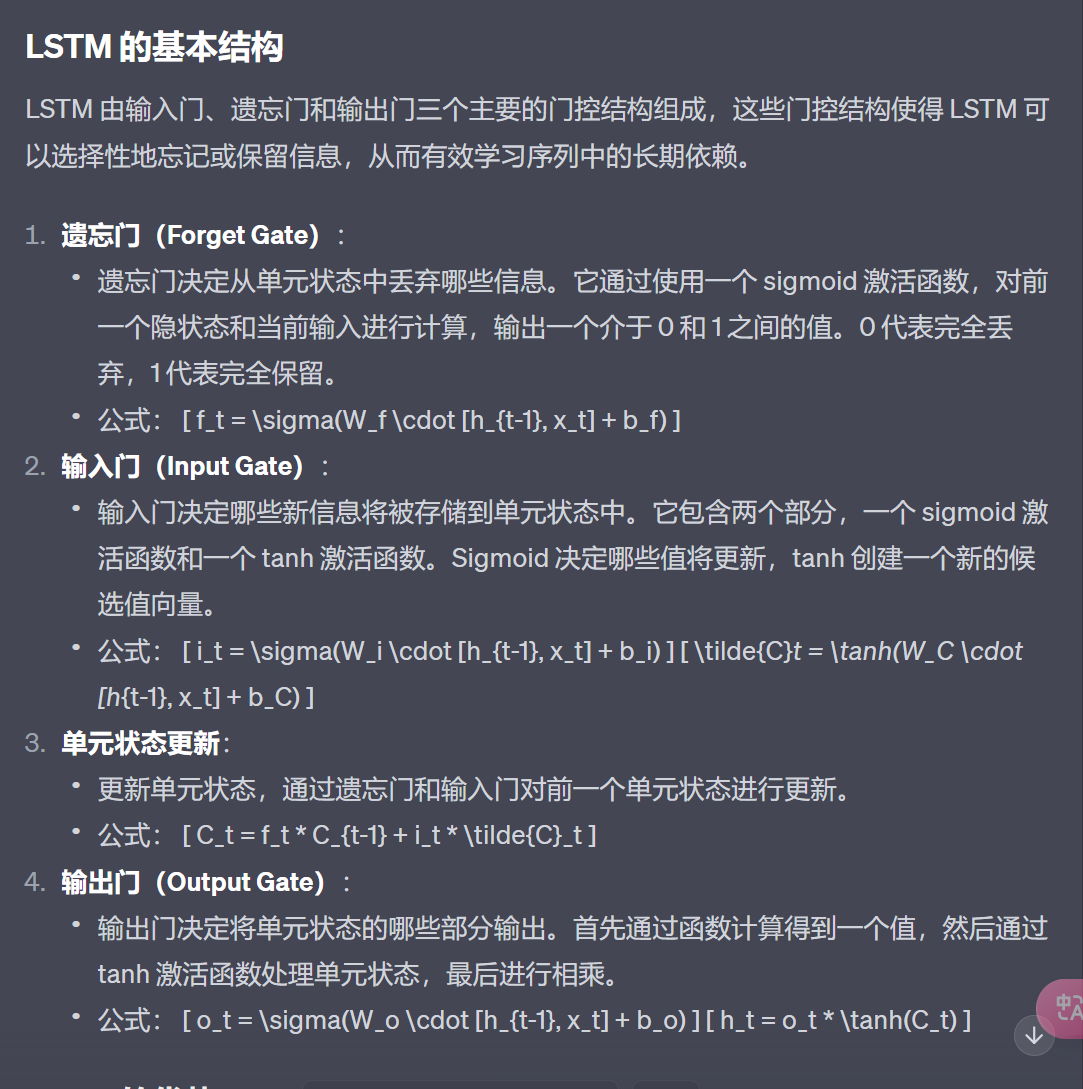

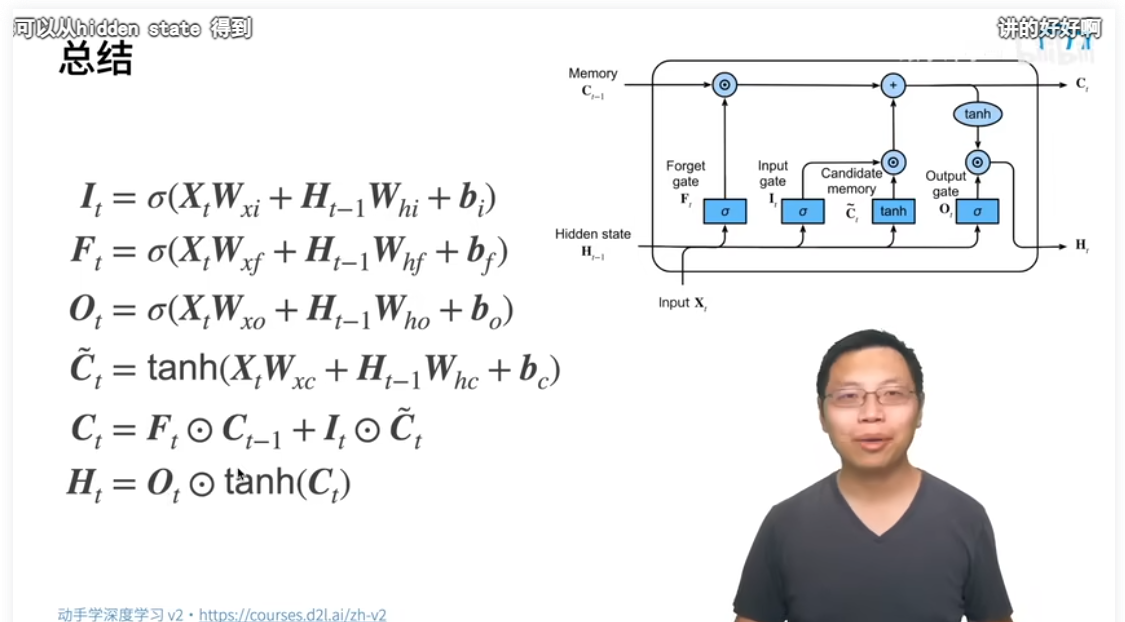

LSTM比RNN多了记忆元 使其能处理更长的数据序列

In [1]:
# LSTM实现
import torch
from torch import nn
from d2l import torch as d2l
#导入数据
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
# 初始化长短期记忆网络（LSTM）中使用的参数

def get_lstm_params(vocab_size, num_hiddens, device):
    """
    初始化 LSTM 的参数。

    参数:
    - vocab_size: 词汇表的大小，输入和输出的特征数量。
    - num_hiddens: 隐藏层的神经元数量。
    - device: 张量存储的设备（CPU 或 GPU）。

    返回:
    - params: 包含 LSTM 所有参数的列表。
    """
    
    num_inputs = num_outputs = vocab_size  # 输入和输出的特征大小设定为词汇表大小

    # 定义一个用于生成权重的正态分布函数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01  # 从标准正态分布生成随机值并缩放

    # 定义一个用于返回三个值（权重和偏置）的辅助函数
    def three():
        return (normal((num_inputs, num_hiddens)),  # 输入到隐藏层的权重
                normal((num_hiddens, num_hiddens)),  # 隐藏层到隐藏层的权重
                torch.zeros(num_hiddens, device=device))  # 隐藏层的偏置，初始化为0

    # 初始化 LSTM 的四个门的参数
    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选状态参数
    
    # 输出层的参数
    W_hq = normal((num_hiddens, num_outputs))  # 从隐藏层到输出层的权重
    b_q = torch.zeros(num_outputs, device=device)  # 输出层的偏置，初始化为0

    # 将所有参数放在一个列表中以便于管理
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]

    # 设置每个参数的 requires_grad 属性为 True，以便在训练过程中计算梯度
    for param in params:
        param.requires_grad_(True)

    return params  # 返回参数列表

In [3]:
# 模型的初始化
def init_lstm_state(batch_size, num_hiddens, device):
    """
    初始化 LSTM 的隐状态和单元状态。

    参数:
    - batch_size: 一个批次中的样本数量。
    - num_hiddens: 隐藏层神经元的数量。
    - device: 张量存储的设备（例如 CPU 或 GPU）。

    返回:
    - 一个包含两个张量的元组：
      - 第一个张量表示隐状态 (h)，形状为 (batch_size, num_hiddens)。
      - 第二个张量表示单元状态 (C)，形状也为 (batch_size, num_hiddens)。
    """

    # 创建两个全零张量，用于初始化隐状态和单元状态
    return (torch.zeros((batch_size, num_hiddens), device=device),  # 隐状态
            torch.zeros((batch_size, num_hiddens), device=device))  # 单元状态

In [4]:
# 实际模型的定义与我们前面讨论的一样： 提供三个门和一个额外的记忆元

def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

perplexity 1.1, 26696.1 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


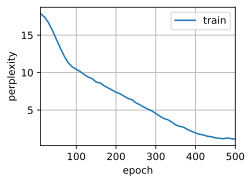

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 248154.2 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


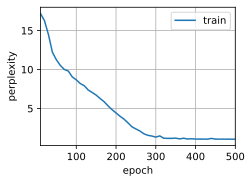

In [6]:
# 简洁实现
# 设置输入特征数量为词汇表的大小
num_inputs = vocab_size  

# 创建一个 LSTM 层，输入特征大小为 num_inputs，隐藏层大小为 num_hiddens
lstm_layer = nn.LSTM(num_inputs, num_hiddens)

# 使用 LSTM 层和词汇表大小创建 RNN 模型实例
model = d2l.RNNModel(lstm_layer, len(vocab))

# 将模型移动到指定的设备（如 CPU 或 GPU）
model = model.to(device)

# 开始训练模型，传入训练数据迭代器、词汇表、学习率、训练轮数和设备
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

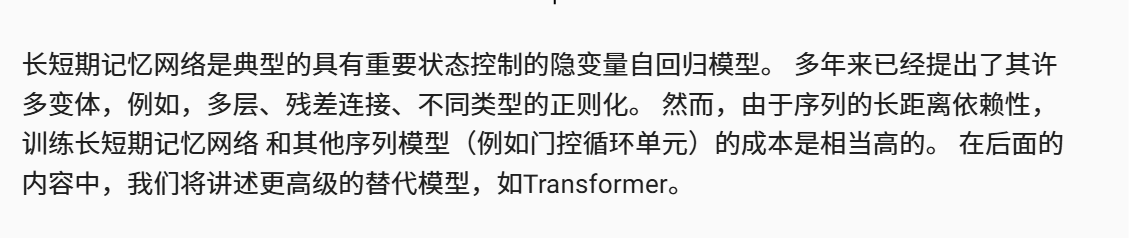

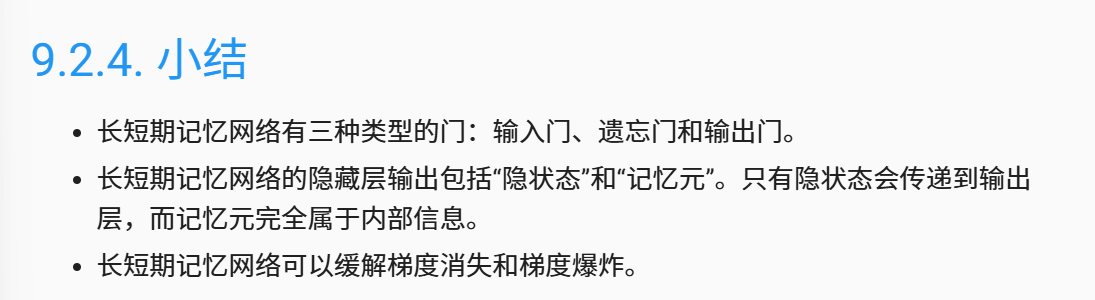